# Using connectivity from Snudda in NEST

This example shows how to create a network in Snudda, and then import the network into NEST to run the simulation there instead of in the default NEURON environment.

## Creating the network connectivity

In [1]:
import os
network_path = os.path.join("networks","snudda_in_nest")

In [2]:
from snudda import SnuddaInit

snudda_data = os.path.join("..", "..", "..", "..", "BasalGangliaData", "data")  # "/home/hjorth/HBP/BasalGangliaData/data/" 
snudda_data = "/home/hjorth/HBP/BasalGangliaData/data/" 
si = SnuddaInit(network_path=network_path, random_seed=12345, snudda_data=snudda_data)
si.define_striatum(num_dSPN=500, num_iSPN=500, num_FS=10, num_LTS=0, num_ChIN=0, neuron_density=80500,
                    volume_type="cube", neurons_dir="$DATA/neurons")
si.write_json()

Using cube for striatum
Neurons for striatum read from /home/hjorth/HBP/BasalGangliaData/data/neurons/striatum
Adding neurons: FS from dir /home/hjorth/HBP/BasalGangliaData/data/neurons/striatum/fs
Adding neurons: dSPN from dir /home/hjorth/HBP/BasalGangliaData/data/neurons/striatum/dspn
Adding neurons: iSPN from dir /home/hjorth/HBP/BasalGangliaData/data/neurons/striatum/ispn
Writing networks/snudda_in_nest/network-config.json


In [3]:
from snudda import SnuddaPlace
spl = SnuddaPlace(network_path=network_path)
spl.place()

Reading SNUDDA_DATA=/home/hjorth/HBP/BasalGangliaData/data/ from networks/snudda_in_nest/network-config.json


In [4]:
from snudda import SnuddaDetect

sd = SnuddaDetect(network_path=network_path)
sd.detect()

Reading SNUDDA_DATA=/home/hjorth/HBP/BasalGangliaData/data/ from networks/snudda_in_nest/network-config.json
No d_view specified, running distribute neurons in serial
Processing hyper voxel : 62/150 (948 neurons)
Processing hyper voxel : 57/150 (947 neurons)
Processing hyper voxel : 61/150 (946 neurons)
Processing hyper voxel : 56/150 (935 neurons)
Processing hyper voxel : 37/150 (865 neurons)
Processing hyper voxel : 32/150 (861 neurons)
Processing hyper voxel : 31/150 (850 neurons)
Processing hyper voxel : 36/150 (846 neurons)
Processing hyper voxel : 87/150 (217 neurons)
Processing hyper voxel : 81/150 (211 neurons)
Processing hyper voxel : 86/150 (205 neurons)
Processing hyper voxel : 82/150 (203 neurons)
Processing hyper voxel : 58/150 (159 neurons)
Processing hyper voxel : 63/150 (142 neurons)
Processing hyper voxel : 55/150 (133 neurons)
Processing hyper voxel : 67/150 (131 neurons)
Processing hyper voxel : 52/150 (130 neurons)
Processing hyper voxel : 60/150 (128 neurons)
Proce

In [5]:
from snudda import SnuddaPrune

sp = SnuddaPrune(network_path=network_path)
sp.prune()

No file networks/snudda_in_nest/pruning_merge_info.json
Worker synapses: 14/6281449 (heap size: 29)
Worker synapses: 4128319/6281449 (heap size: 24)
Worker synapses: 6281449/6281449 (heap size: 0)
Read 6281449 out of total 6281449 synapses
Read 75 out of total 75 gapJunctions


# Setup input 

-- TODO: Check that NEST imports the input spikes

In [6]:
input_config = {
    "dSPN": {
        "Ctx" : {
            "generator" : "poisson",
            "start" : [0, 4, 5],
            "end" : [4, 5, 10],
            "frequency" : [2, 4, 2],
            "conductance" : 0.5e-9,
            "nInputs" : 20,
            "populationUnitCorrelation" : [0.5, 1.0, 0.5],
            "jitter" : 0.01,	    
            "modFile": "tmGlut"
        }
    },

    "iSPN": {
        "Ctx" : {
            "generator" : "poisson",
            "start" : [0, 5],
            "end" : [3, 10],	    
            "frequency" : 1,
            "conductance" : 0.5e-9,
            "nInputs" : 10,
            "jitter" : 0.01,
            "populationUnitCorrelation" : 0.2,
            "populationUnitID" : 1,
            "modFile": "tmGlut"
        }
    },
    
    "FS": {
        "Ctx" : {
            "generator" : "poisson",
            "start" : [0, 5],
            "end" : [3, 10],	    
            "frequency" : 1,
            "conductance" : 0.5e-9,
            "nInputs" : 10,
            "jitter" : 0.01,
            "populationUnitCorrelation" : 0.2,
            "populationUnitID" : 1,
            "modFile": "tmGlut"
        }
    }
}

from snudda.input import SnuddaInput
si = SnuddaInput(network_path=network_path, 
                 input_config_file=input_config,
                 verbose=False)
si.generate()

Reading SNUDDA_DATA=/home/hjorth/HBP/BasalGangliaData/data/ from networks/snudda_in_nest/network-config.json
Writing spikes to networks/snudda_in_nest/input-spikes.hdf5


In [7]:
from snudda.utils.export_sonata import ExportSonata
se = ExportSonata(network_path=network_path)

Using input file: networks/snudda_in_nest/input-spikes.hdf5
Copying morphologies
Copying /home/hjorth/HBP/BasalGangliaData/data/neurons/striatum/dspn/str-dspn-e150917_c6_D1-m21-6-DE-v20211028/morphology/21-6-DE-cor-rep-ax-res3-var5.swc to networks/snudda_in_nest/SONATA/components/morphologies/21-6-DE-cor-rep-ax-res3-var5.swc
Copying /home/hjorth/HBP/BasalGangliaData/data/neurons/striatum/dspn/str-dspn-e150917_c6_D1-m21-6-DE-v20211028/morphology/21-6-DE-cor-rep-ax-res3-var0.swc to networks/snudda_in_nest/SONATA/components/morphologies/21-6-DE-cor-rep-ax-res3-var0.swc
Copying /home/hjorth/HBP/BasalGangliaData/data/neurons/striatum/ispn/str-ispn-e150908_c4_D2-m51-5-DE-v20211026/morphology/51-5-DE-cor-rep-ax-res3-var6.swc to networks/snudda_in_nest/SONATA/components/morphologies/51-5-DE-cor-rep-ax-res3-var6.swc
Copying /home/hjorth/HBP/BasalGangliaData/data/neurons/striatum/dspn/str-dspn-e150917_c6_D1-m21-6-DE-v20211028/morphology/21-6-DE-cor-rep-ax-res3-var2.swc to networks/snudda_in_nest

In [8]:
si = None
spl = None
sd = None
sp = None
se = None

# Import network into NEST and run simulation

In [9]:
import nest

nest.ResetKernel()

base_dir = os.path.join(network_path, "SONATA")
net_config = os.path.join(base_dir, "circuit_config.json")
sim_config = os.path.join(base_dir,"simulation_config.json")

sonata_net = nest.SonataNetwork(net_config, sim_config)
# node_collections = sonata_net.Create()

node_collections = sonata_net.BuildNetwork()

s_rec_dspn = nest.Create("spike_recorder")
s_rec_ispn = nest.Create("spike_recorder")
s_rec_fs = nest.Create("spike_recorder")

# record_node_ids = [1, 80, 160, 240, 270]
# nest.Connect(node_collections[pop_name][record_node_ids], s_rec)

nest.Connect(node_collections["dSPN"], s_rec_dspn)
nest.Connect(node_collections["iSPN"], s_rec_ispn)
nest.Connect(node_collections["FS"], s_rec_fs)


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.4.0-post0.dev0
 Built: Jun  1 2023 12:32:32

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.


Jun 07 14:34:02 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.


In [10]:
# If we need to add separate noise. 
# Currently the SONATA specified inputs exist (but according to SONATA documentation it should target virtual neurons), but are not properly connected.

exc_rate = 4.5

exc_noise_fs = nest.Create('poisson_generator', 1300)
exc_noise_dspn = nest.Create('poisson_generator', 1500)
exc_noise_ispn = nest.Create('poisson_generator', 1050)

exc_noise_fs.set(rate=exc_rate)
exc_noise_dspn.set(rate=exc_rate)
exc_noise_ispn.set(rate=exc_rate)

nest.Connect(exc_noise_fs, node_collections["FS"], 'all_to_all', {'weight': +0.5})
nest.Connect(exc_noise_dspn, node_collections["dSPN"], 'all_to_all', {'weight': +0.5})
nest.Connect(exc_noise_ispn, node_collections["iSPN"], 'all_to_all', {'weight': +0.5})

In [11]:
sonata_net.Simulate()


Jun 07 14:34:02 NodeManager::prepare_nodes [Info]: 
    Preparing 4863 nodes for simulation.

Jun 07 14:34:03 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 4863
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jun 07 14:36:17 SimulationManager::run [Info]: 
    Simulation finished.


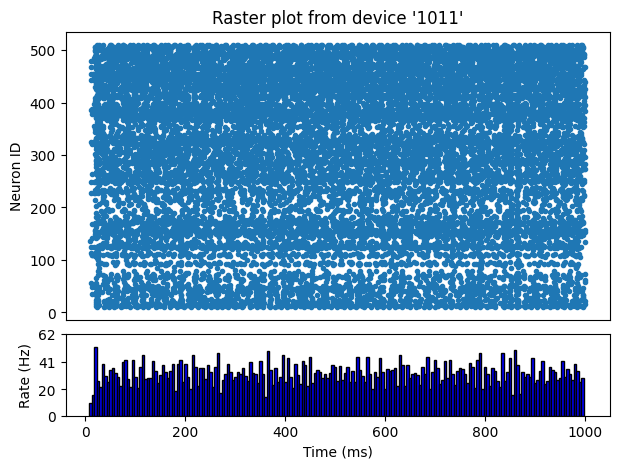

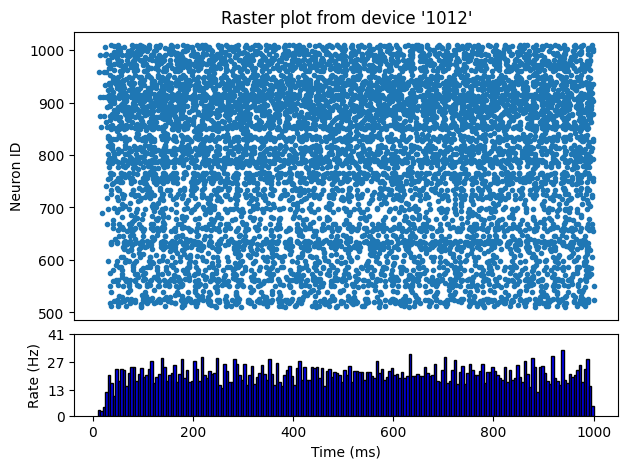

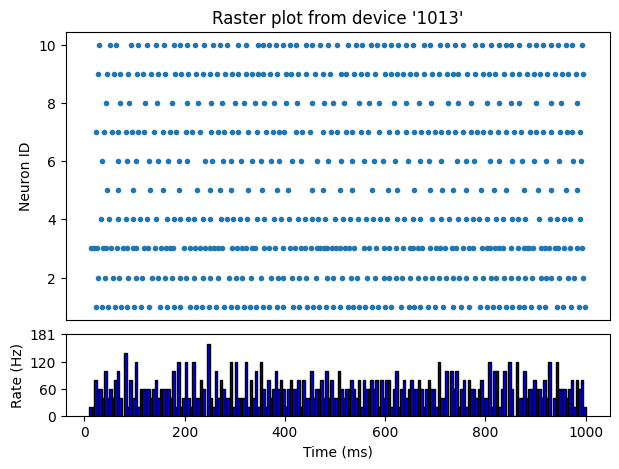

In [12]:
import matplotlib.pyplot as plt
nest.raster_plot.from_device(s_rec_dspn)
nest.raster_plot.from_device(s_rec_ispn)
nest.raster_plot.from_device(s_rec_fs)
plt.show()